In [1]:
from tensorflow.keras.models import load_model
from data import *
import os

In [2]:
# for Gunpowder
ZARR_TEST_FOLDER = '../../../../data/cells/raw/zarr/test/'
MODEL_FOLDER     = '../../../../data/cells/models/'
MODELS_FILES = ['unet_cells.hdf5','08_09_2020_unet_v1_cells.hdf5',
                '09_09_2020_unet_v1_cells.hdf5','09_09_2020_unet_v2_cells.hdf5',
                '09_09_2020_unet_v3_cells.hdf5','09_09_2020_unet_v4_cells.hdf5']
PRED_STRINGS = ['pred_v1','pred_v2',
                'pred_v3','pred_v4',
                'pred_v5','pred_v6']
gp_batch_size= 12
gp_voxel_shape = [1,1,1]
gp_input_shape= [256,256,4]
gp_output_shape = [256,256,4]

# For unet
OUTPUT_PATH = '../../../../data/cells/models/'
model_name = 'unet_cells.hdf5'
# unet_input_size = (256,256,4)
# unet_output_size = 4

In [3]:
files = os.listdir(ZARR_TEST_FOLDER)
files = [os.path.join(ZARR_TEST_FOLDER,f) for f in files ]
print(files)
models = [os.path.join(MODEL_FOLDER,f) for f in MODELS_FILES ]
print(models)

['../../../../data/cells/raw/zarr/test/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_18_ch_4.zarr']
['../../../../data/cells/models/unet_cells.hdf5', '../../../../data/cells/models/08_09_2020_unet_v1_cells.hdf5', '../../../../data/cells/models/09_09_2020_unet_v1_cells.hdf5', '../../../../data/cells/models/09_09_2020_unet_v2_cells.hdf5', '../../../../data/cells/models/09_09_2020_unet_v3_cells.hdf5', '../../../../data/cells/models/09_09_2020_unet_v4_cells.hdf5']


### Block generation to prediction

In [4]:
def getBlocks(img_size, block_size):
    w = img_size[0] // block_size[0]
    h = img_size[1] // block_size[1]
    result = []
    print("We have {} - {} blocks ".format(w,h))
    for i in range(w):
        for j in range(h):
            x1 = i*block_size[0]
            y1 = j*block_size[1]
            x2 = x1+block_size[0]
            y2 = y1 + block_size[1]
            result.append([x1,y1,x2,y2])
    return result
    
blocks = getBlocks([1024,1024,4],[256,256,4])
blocks

We have 4 - 4 blocks 


[[0, 0, 256, 256],
 [0, 256, 256, 512],
 [0, 512, 256, 768],
 [0, 768, 256, 1024],
 [256, 0, 512, 256],
 [256, 256, 512, 512],
 [256, 512, 512, 768],
 [256, 768, 512, 1024],
 [512, 0, 768, 256],
 [512, 256, 768, 512],
 [512, 512, 768, 768],
 [512, 768, 768, 1024],
 [768, 0, 1024, 256],
 [768, 256, 1024, 512],
 [768, 512, 1024, 768],
 [768, 768, 1024, 1024]]

In [7]:
for model_path,pred_str in zip(models,PRED_STRINGS): 
    for f in files:
        print('processing {}'.format(f))
        batches = generate_raw_batch(f,blocks)
        model = load_model(model_path)
        results = model.predict(np.array(batches))
        print('predicted {}'.format(f))
        add_data(zarr_file= f,name= pred_str,
                 img_shape= (1024, 1024, 4),boxes_positions= blocks,data = results)

processing ../../../../data/cells/raw/zarr/test/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_18_ch_4.zarr
Processing block [0, 0, 256, 256]
Processing block [0, 256, 256, 512]
Processing block [0, 512, 256, 768]
Processing block [0, 768, 256, 1024]
Processing block [256, 0, 512, 256]
Processing block [256, 256, 512, 512]
Processing block [256, 512, 512, 768]
Processing block [256, 768, 512, 1024]
Processing block [512, 0, 768, 256]
Processing block [512, 256, 768, 512]
Processing block [512, 512, 768, 768]
Processing block [512, 768, 768, 1024]
Processing block [768, 0, 1024, 256]
Processing block [768, 256, 1024, 512]
Processing block [768, 512, 1024, 768]
Processing block [768, 768, 1024, 1024]
predicted ../../../../data/cells/raw/zarr/test/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_18_ch_4.zarr
processing ../../../../data/cells/raw/zarr/test/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_18_ch_4.zarr
Processing block [0, 0, 256, 256]
Processing block [0, 256, 256, 512]
Processing block [0

#### Append to data 'prediction' with the result of prediction assumbled

In [8]:
root = zarr.open(files[0], mode='r')

In [10]:
root.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,9
No. arrays,9
No. groups,0
Arrays,"ground_truth, instances, pred_v1, pred_v2, pred_v3, pred_v4, pred_v5, pred_v6, raw"


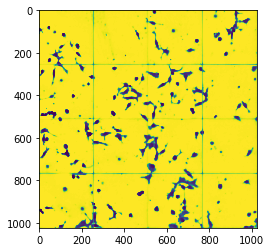

In [12]:
plt.imshow(root['pred_v3'][:][:,:,0])